In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from utils.data_utils import *

In [2]:
# 更改 utils/data_utils.py 中的自訂 function 可重新 reload
from importlib import reload
from utils import data_utils
reload(data_utils)
from utils.data_utils import *

# Read data

In [3]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/'
load = pd.read_pickle(path + 'load_nyisocom.pickle')
print(f'原始資料數量: {load.shape}')

原始資料數量: (2174180, 3)


In [4]:
# 2005-01-31 之前, NYC 和 LONG IL 是並在一起, 資料不適合使用
load = load[(load['Date']>='2005-01-31 00:00:00')]
# load = load[(load['Date']>='2005-01-31 00:00:00') & (load['Date']<='2016-12-31 23:00:00')]
print(f'選定區間後原始資料數量: {load.shape}')

選定區間後原始資料數量: (1823975, 3)


# Clean data

## 原先資料就有的NA 
(後面NA一起處理)

In [5]:
print(load['Load'].isna().sum())
# load[load['Load'].isna()]

33


## unusal values

### Explore

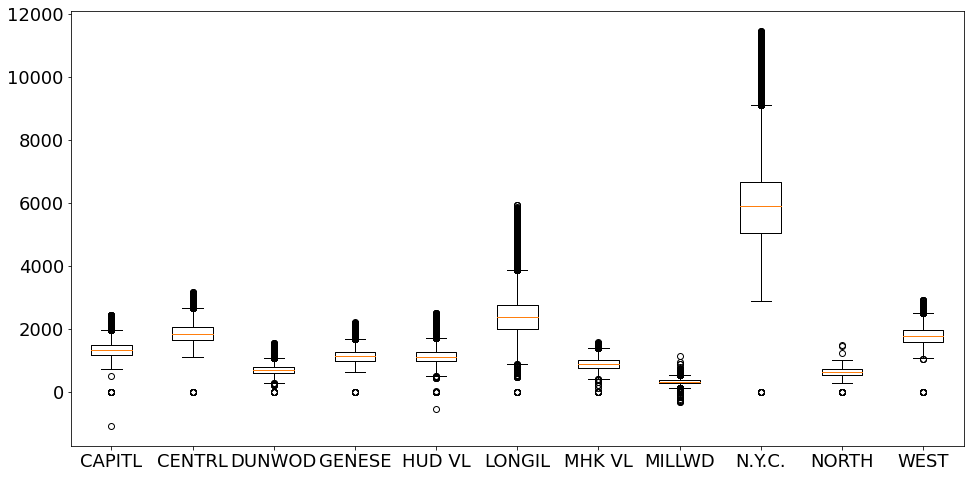

In [7]:
df = load

load_data_by_zone = []
# 遍歷每個類別，將相應的Load數據添加到列表中
for zone, data in df.groupby('Zone')['Load']:
    load_data_by_zone.append(data)

# 繪製箱形圖
plt.figure(figsize=(16, 8))
plt.boxplot(load_data_by_zone, labels=df['Zone'].unique(), vert=True)
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

plt.show()

### Remove 0 and negative

In [8]:
print(f'刪除前資料數量: {df.shape}')
non_pos = df[df['Load']<=0]
print(f'小於等於0的數量: {non_pos.shape}')
load_drop = df.drop(non_pos.index) 
print(f'刪除後資料數量: {load_drop.shape}')

刪除前資料數量: (1823975, 3)
小於等於0的數量: (115, 3)
刪除後資料數量: (1823860, 3)


In [9]:
zones = load['Zone'].unique()
for zone in zones:
    non_pos = df[(df['Load']<=0) & (df['Zone']==zone)]
    print(f'{zone} 小於等於0的數量: {non_pos.shape}')

CAPITL 小於等於0的數量: (10, 3)
CENTRL 小於等於0的數量: (9, 3)
DUNWOD 小於等於0的數量: (9, 3)
GENESE 小於等於0的數量: (9, 3)
HUD VL 小於等於0的數量: (10, 3)
LONGIL 小於等於0的數量: (9, 3)
MHK VL 小於等於0的數量: (9, 3)
MILLWD 小於等於0的數量: (23, 3)
N.Y.C. 小於等於0的數量: (9, 3)
NORTH 小於等於0的數量: (9, 3)
WEST 小於等於0的數量: (9, 3)


## duplicate


### Explore

In [10]:
df = load_drop

# 確認有多少重複值
duplicates = df[df.duplicated(subset=['Date', 'Zone'], keep = False)]
print(f'重複筆數：{duplicates.shape}')

print(duplicates.head(1))
df[(df['Date'] == '2014-11-02 01:00:00')&(df['Zone']=='N.Y.C.')]

重複筆數：(350, 3)
                      Date    Zone    Load
490147 2005-03-26 01:00:00  CENTRL  1692.1


,Date,Zone,Load
1812720,2014-11-02 01:00:00,N.Y.C.,4400.5
1812721,2014-11-02 01:00:00,N.Y.C.,4221.8


In [11]:
zones = load['Zone'].unique()
for zone in zones:
    df_zone = df[(df['Zone']==zone)]
    duplicates = df_zone[df_zone.duplicated(subset=['Date', 'Zone'])]
    print(f'{zone} 重複筆數: {duplicates.shape}')

CAPITL 重複筆數: (15, 3)
CENTRL 重複筆數: (16, 3)
DUNWOD 重複筆數: (16, 3)
GENESE 重複筆數: (16, 3)
HUD VL 重複筆數: (16, 3)
LONGIL 重複筆數: (16, 3)
MHK VL 重複筆數: (16, 3)
MILLWD 重複筆數: (16, 3)
N.Y.C. 重複筆數: (16, 3)
NORTH 重複筆數: (16, 3)
WEST 重複筆數: (16, 3)


In [12]:
df = load_drop

# 確認有多少重複值
duplicates_first = df[df.duplicated(subset=['Date', 'Zone'], keep = "first")]
duplicates_last = df[df.duplicated(subset=['Date', 'Zone'], keep = "last")]

In [13]:
new_df = pd.merge(duplicates_first, duplicates_last,  how='left', left_on=['Date','Zone'], right_on = ['Date','Zone'])
new_df

,Date,Zone,Load_x,Load_y
0,2005-03-26 01:00:00,CENTRL,1693.6,1692.1
1,2005-03-26 01:00:00,DUNWOD,544.7,543.9
2,2005-03-26 01:00:00,GENESE,888.1,887.1
3,2005-03-26 01:00:00,HUD VL,938.1,937.3
4,2005-03-26 01:00:00,LONGIL,1872.8,1870.3
...,...,...,...,...
170,2021-11-07 01:00:00,MHK VL,724.1157,733.9323
171,2021-11-07 01:00:00,MILLWD,270.0057,277.6956
172,2021-11-07 01:00:00,N.Y.C.,4104.6106,4284.5644
173,2021-11-07 01:00:00,NORTH,608.609,612.232


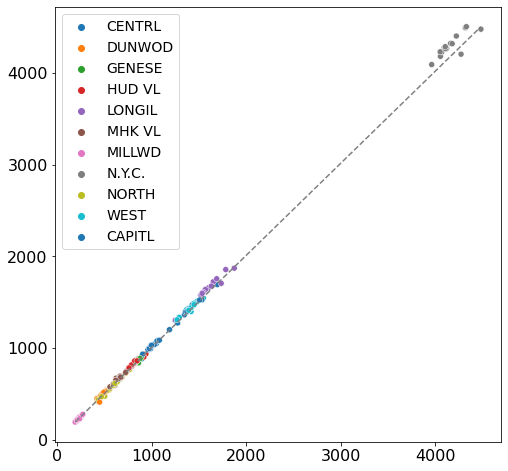

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for categorical colormap

plt.figure(figsize=(8, 8)) 
# Assuming new_df is your DataFrame
scatterplot = sns.scatterplot(x='Load_x', y='Load_y', hue='Zone', data=new_df, palette='tab10')

# Adding labels and title
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.title('', fontsize=20)

# Set tick label font sizes
plt.tick_params(axis='both', labelsize=16)

# Adjust legend text size
scatterplot.legend(fontsize=14)

# Add a 45-degree line
plt.plot([min(new_df['Load_x']), max(new_df['Load_x'])], [min(new_df['Load_y']), max(new_df['Load_y'])], linestyle='--', color='gray')

# Display the plot
plt.show()


### Take an average of duplicates

In [15]:
# about 1m 10s
df= load_drop

# 重複中有兩筆資料的取平均
print(f'刪除前資料數量: {df.shape}')
duplicates = df[df.duplicated(subset=['Date', 'Zone'])]

print(f'重複筆數: {duplicates.shape}')
df_drop = df.groupby(['Date', 'Zone'])['Load'].mean().reset_index()
print(f'刪除後資料數量: {df_drop.shape}')

load_drop = df_drop

刪除前資料數量: (1823860, 3)
重複筆數: (175, 3)
刪除後資料數量: (1823685, 3)


## NA 

In [16]:
df = load_drop

print(f'目前資料數量: {df.shape}')
df_all_time = merge_all_time(df)
print(f'補上所有時間後資料數量: {df_all_time.shape}')
print(f'沒紀錄數量(包含原本是<=0被drop掉的): {df_all_time.shape[0]-df.shape[0]}')
min_date = df['Date'].min(); max_date = df['Date'].max()
print(f'min: {min_date}')
print(f'max: {max_date}')

# 驗算
hours_df = pd.DataFrame({'Date': pd.date_range(start = df['Date'].min(), end = df['Date'].max(), freq = '1H') })
print(f'驗算 - 所有時間點 x 11 zones:{hours_df.shape[0]*11}')



df_all_time = df_all_time

目前資料數量: (1823685, 3)
補上所有時間後資料數量: (1823976, 3)
沒紀錄數量(包含原本是<=0被drop掉的): 291
min: 2005-01-31 00:00:00
max: 2023-12-31 23:00:00
驗算 - 所有時間點 x 11 zones:1823976


In [17]:
for zone in zones:
    num = df_all_time[df_all_time['Zone']==zone].shape[0] - df[df['Zone']==zone].shape[0]
    print(f'{zone} 沒紀錄數量(包含原本是<=0被drop掉的): {num}')

CAPITL 沒紀錄數量(包含原本是<=0被drop掉的): 26
CENTRL 沒紀錄數量(包含原本是<=0被drop掉的): 25
DUNWOD 沒紀錄數量(包含原本是<=0被drop掉的): 25
GENESE 沒紀錄數量(包含原本是<=0被drop掉的): 25
HUD VL 沒紀錄數量(包含原本是<=0被drop掉的): 26
LONGIL 沒紀錄數量(包含原本是<=0被drop掉的): 25
MHK VL 沒紀錄數量(包含原本是<=0被drop掉的): 25
MILLWD 沒紀錄數量(包含原本是<=0被drop掉的): 39
N.Y.C. 沒紀錄數量(包含原本是<=0被drop掉的): 25
NORTH 沒紀錄數量(包含原本是<=0被drop掉的): 25
WEST 沒紀錄數量(包含原本是<=0被drop掉的): 25


In [18]:
for zone in zones:
    df_onezone = df_all_time.loc[df_all_time['Zone'] == zone,]
    print(f"{zone} total NA number (包含原本存在的3個NA): {df_onezone['Load'].isna().sum()}") 

CAPITL total NA number (包含原本存在的3個NA): 29
CENTRL total NA number (包含原本存在的3個NA): 28
DUNWOD total NA number (包含原本存在的3個NA): 28
GENESE total NA number (包含原本存在的3個NA): 28
HUD VL total NA number (包含原本存在的3個NA): 29
LONGIL total NA number (包含原本存在的3個NA): 28
MHK VL total NA number (包含原本存在的3個NA): 28
MILLWD total NA number (包含原本存在的3個NA): 42
N.Y.C. total NA number (包含原本存在的3個NA): 28
NORTH total NA number (包含原本存在的3個NA): 28
WEST total NA number (包含原本存在的3個NA): 28


### Explore: 以 NYC 為例

In [136]:
df = df_all_time

# 找尋 one zone 的 NA
zone = 'N.Y.C.'
df_onezone = df.loc[df['Zone'] == zone,]
print(f"NYC 資料數量: {df_onezone.shape}")
print(f"NYC NA number (包含原本存在的3個NA): {df_onezone['Load'].isna().sum()}") 

df_onezone = df_onezone

NYC 資料數量: (104472, 3)
NYC NA number (包含原本存在的3個NA): 21


#### visualize NA on heatmap

In [ ]:
df = df_onezone

# 呈現 NA heatmap
# vis_na(df, figsize_width = 16, figsize_height = 80) # (END) ALL 至 2023-09-23 23:00:00 (154536)

In [ ]:
df = df_onezone

# 計算年 NA
year_na_count = count_year_na(df)
year_na_count.to_frame()

,Load
Date,
2005-12-31,5
2006-12-31,4
2007-12-31,1
2008-12-31,1
2009-12-31,1
2010-12-31,2
2011-12-31,1
2012-12-31,1
2013-12-31,1


### Impute: All zones 每個區域用STL各自補

In [137]:
df = df_all_time

'''
確認：呈現每個區域總NA值和分年NA值，確認 select_period 是否只看一個 zone 就決定
'''
total_na, month_na = count_zone_na(df)
print(total_na)
# for i in range(len(month_na)):
#     print(month_na[i])
sum(total_na)

[22, 21, 21, 21, 22, 21, 21, 35, 21, 21, 21]


247

#### 先補 NYC

STL 補值後 NA number: 0


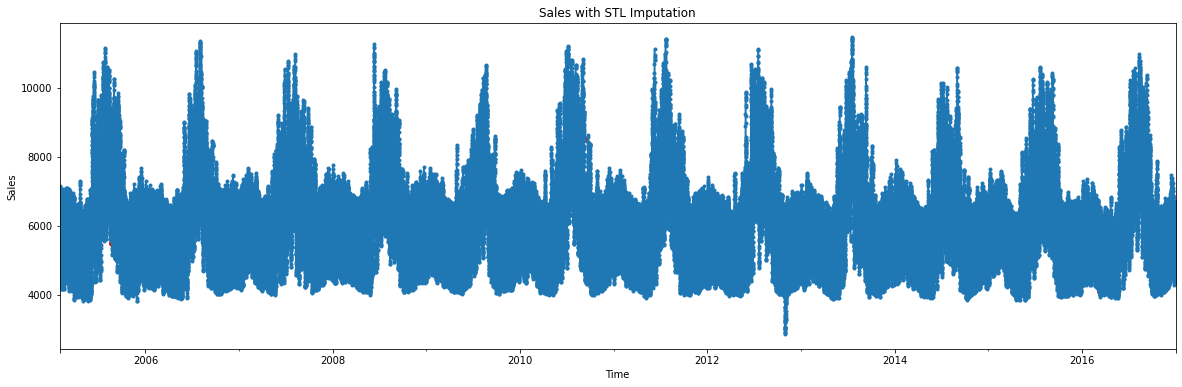

In [138]:
df = df_all_time.loc[df_all_time['Zone'] == 'N.Y.C.']

df_impute_stl, imputed_indices = impute_stl(df)
print(f"STL 補值後 NA number: {df_impute_stl['Load'].isna().sum()}")

plot_impute_result(df_impute_stl, imputed_indices)

In [139]:
# # explore the lowest part
# df = df_impute_stl.iloc[67089:68543,]

# plt.figure(figsize=[20, 6])
# df['Load'].plot(style='.-',  label='Load')

# plt.title("")
# plt.ylabel("Sales")
# plt.xlabel("Time")
# plt.show()

In [140]:
# Date 從 index 轉成 columne
df_one = df_impute_stl
df_one['Date'] = df_one.index
df_one = df_one.reset_index(drop=True)

# 存成 list (train_test_select 吃 list)
df_impute_stl_ls = [df_one] 

In [143]:
file_name = "nyiso_NYC_impute_stl.pkl" 

path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/'
open_file = open(path + file_name, "wb")
pickle.dump(df_impute_stl_ls, open_file)
open_file.close()

#### All

In [144]:
df = df_all_time

'''
做補值：每個區域各自補
Time: About 11.5 mins
'''
zones = df['Zone'].unique()
# zones = ['CAPITL', 'N.Y.C.']
all_impute_stl = []
imputed_indices_ls = []
for zone in zones: # 11

    # one zone in one loop
    result = df.loc[df['Zone'] == zone,]
    # imputation
    impute_result, imputed_indices = impute_stl(result)
    # index -> column
    impute_result['Date'] = impute_result.index
    impute_result = impute_result.reset_index(drop=True)  
    # save in a list
    all_impute_stl.append(impute_result)
    imputed_indices_ls.append(imputed_indices)
    
all_impute_stl_ls = [pd.concat(all_impute_stl, axis=0)]

In [145]:
# 上面轉換花費太多時間，儲存成 pkl

file_name = "nyiso_all_impute_stl.pkl"

path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/'
open_file = open(path + file_name, "wb")
pickle.dump(all_impute_stl_ls, open_file)
open_file.close()

In [148]:
all_impute_stl_ls[0].shape

(1149192, 3)

In [146]:
df = all_impute_stl_ls[0]
for zone in zones:
    print(zone)
    df_zone = df[(df['Zone']==zone)]

    mean = round(np.mean(df_zone['Load']),0)
    sd = round(np.std(df_zone['Load']),0)

    print(f'mean: {mean}')
    print(f'sd: {sd}')

CAPITL
mean: 1341.0
sd: 253.0
CENTRL
mean: 1879.0
sd: 297.0
DUNWOD
mean: 706.0
sd: 167.0
GENESE
mean: 1144.0
sd: 212.0
HUD VL
mean: 1171.0
sd: 253.0
LONGIL
mean: 2542.0
sd: 662.0
MHK VL
mean: 899.0
sd: 173.0
MILLWD
mean: 322.0
sd: 84.0
N.Y.C.
mean: 6138.0
sd: 1304.0
NORTH
mean: 648.0
sd: 133.0
WEST
mean: 1810.0
sd: 258.0


# Export data: 產出要使用的資料 (pd to np array)

要產生可以餵進 SSSD code 的資料格式 np array (observation, channel, length)

## Dataset 3: 8 days + STL + z normalization

### NYC

In [115]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/nyiso_NYC_impute_stl_20050131to20231231.pkl", "rb")
df_impute_stl_ls = pickle.load(open_file)
open_file.close()

In [117]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/nyiso_NYC_impute_stl.pkl", "rb")
df_impute_stl_ls_new = pickle.load(open_file)
open_file.close()

In [142]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_3/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = ['N.Y.C.']

for index in range(len(zones)):
    load_array_train, load_array_test = train_test_select(df_impute_stl_ls, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    # np.save(path + '/zone/'+zones[index]+'_train.npy', load_array_train)
    # np.save(path + '/zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    # np.save(path + '/zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    # np.save(path + '/zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

In [5]:
a = np.array([[1,2,np.nan], [4,5,6]])
print(a.shape)
b = a[~np.isnan(a).any(axis=1)]
print(b.shape)

(2, 3)
(1, 3)


### Each zone

In [24]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/nyiso_all_impute_stl.pkl", "rb")
all_impute_stl_ls = pickle.load(open_file)
open_file.close()

In [46]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_3/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = all_impute_stl_ls[0]['Zone'].unique()

for index in range(len(zones)):
    load_array_train, load_array_test = train_test_select(all_impute_stl_ls, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    np.save(path + '/zone/'+zones[index]+'_train.npy', load_array_train)
    np.save(path + '/zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(path + '/zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(path + '/zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

### All

In [3]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/nyiso_all_impute_stl.pkl", "rb")
all_impute_stl_ls = pickle.load(open_file)
open_file.close()

In [4]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_3/'
days_window = 8 # 幾天一組（也就是預測第幾天）
load_array_train, load_array_test = train_test_select(all_impute_stl_ls, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 11,
                                                      days_window = days_window,
                                                      zone_name = 'ALL')
print(load_array_train.shape)
print(load_array_test.shape)  

# save
np.save(path + 'all/load_array_all_train.npy', load_array_train)
np.save(path + 'all/load_array_all_test.npy', load_array_test)

# Normalization

load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

# check: if days_normalized = days_window, the sum of squares = 24*days_window
# np.sum(np.square(load_array_test_stdd[0,:,0]))

# save
np.save(path + 'all/load_array_all_train_stdd.npy', load_array_train_stdd)
np.save(path + 'all/load_array_all_test_stdd.npy', load_array_test_stdd)

(47003, 192, 1)
(803, 192, 1)


(4273, 11, 192)


### Mix

In [10]:
open_file = open("/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/pickle/nyiso_all_impute_stl.pkl", "rb")
all_impute_stl_ls = pickle.load(open_file)
open_file.close()

In [19]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_3/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = all_impute_stl_ls[0]['Zone'].unique()

load_array_mix_train = np.concatenate([np.load(path + '/zone/'+zone+'_train.npy') for zone in zones]) 
load_array_mix_test = np.concatenate([np.load(path + '/zone/'+zone+'_test.npy') for zone in zones]) 
load_array_mix_train_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_train_stdd.npy') for zone in zones]) 
load_array_mix_test_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_test_stdd.npy') for zone in zones]) 

np.save(path + 'mix/load_array_mix_train.npy', load_array_mix_train)
np.save(path + 'mix/load_array_mix_test.npy', load_array_mix_test)
np.save(path + 'mix/load_array_mix_train_stdd.npy', load_array_mix_train_stdd)
np.save(path + 'mix/load_array_mix_test_stdd.npy', load_array_mix_test_stdd)

In [110]:
# data = np.load(path + 'mix/load_array_mix_train_stdd.npy')
# data.shape

## Dataset 4: 8 days + remove na + z normalization

移除 NA 在 'train_test_select' 內執行

In [90]:
df_all_time_ls = [df_all_time]

### Each zone

In [95]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = df_all_time['Zone'].unique()

for index in range(len(zones)):
    load_array_train, load_array_test = train_test_select(df_all_time, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    np.save(path + 'zone/'+zones[index]+'_train.npy', load_array_train)
    np.save(path + 'zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(path + 'zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(path + 'zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

In [155]:
load_array_train, load_array_test = train_test_select(df_all_time, 
                                                    train_start = '2005-01-31 00:00:00',
                                                    train_end = '2016-10-19 23:00:00', 
                                                    test_start = '2016-10-13 00:00:00',
                                                    test_end = '2016-12-31 23:00:00',
                                                    zone_number = 1,
                                                    days_window = 8,
                                                    zone_name = 'N.Y.C.')

In [156]:
load_array_train.shape

(4121, 192, 1)

### All

In [157]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
days_window = 8 # 幾天一組（也就是預測第幾天）
load_array_train, load_array_test = train_test_select(df_all_time, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 11,
                                                      days_window = days_window,
                                                      zone_name = 'ALL')
print(load_array_train.shape)
print(load_array_test.shape)  

# save
np.save(path + 'all/load_array_all_train.npy', load_array_train)
np.save(path + 'all/load_array_all_test.npy', load_array_test)

# Normalization

load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

# check: if days_normalized = days_window, the sum of squares = 24*days_window
# np.sum(np.square(load_array_test_stdd[0,:,0]))

# save
np.save(path + 'all/load_array_all_train_stdd.npy', load_array_train_stdd)
np.save(path + 'all/load_array_all_test_stdd.npy', load_array_test_stdd)

(4074, 192, 11)
(73, 192, 11)


### Mix

In [97]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = all_impute_stl_ls[0]['Zone'].unique()

load_array_mix_train = np.concatenate([np.load(path + '/zone/'+zone+'_train.npy') for zone in zones]) 
load_array_mix_test = np.concatenate([np.load(path + '/zone/'+zone+'_test.npy') for zone in zones]) 
load_array_mix_train_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_train_stdd.npy') for zone in zones]) 
load_array_mix_test_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_test_stdd.npy') for zone in zones]) 

np.save(path + 'mix/load_array_mix_train.npy', load_array_mix_train)
np.save(path + 'mix/load_array_mix_test.npy', load_array_mix_test)
np.save(path + 'mix/load_array_mix_train_stdd.npy', load_array_mix_train_stdd)
np.save(path + 'mix/load_array_mix_test_stdd.npy', load_array_mix_test_stdd)

### zone split

In [34]:
path = "/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/"

# creat 'zone_split' folder
if not os.path.exists(path+'zone_split'):
    os.makedirs(path+'zone_split')

# create list containing file names of training data
file_ls = os.listdir(path+'zone')
train_files_ls = [file for file in file_ls if 'train' in file]

for file in train_files_ls:
    # read
    data_npy = np.load(path+'zone/'+file)

    # 將資料分成 I1 和 I2
    np.random.seed(42)

    random_indices = np.random.choice(data_npy.shape[0], data_npy.shape[0]//2, replace=False)
    remaining_indices = np.setdiff1d(np.arange(data_npy.shape[0]), random_indices)

    sample_I1 = data_npy[random_indices]
    sample_I2 = data_npy[remaining_indices]

    # save
    np.save(path+'zone_split/I1_'+file, sample_I1)
    np.save(path+'zone_split/I2_'+file, sample_I2)


## Dataset 5:  8 days + remove na + range normalization

移除 NA 在 'train_test_select' 內執行

In [ ]:
df_all_time_ls = [df_all_time]

### Each zone

In [106]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = df_all_time['Zone'].unique()

for index in range(len(zones)):   
    load_array_train, load_array_test = train_test_select(df_all_time, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    np.save(path + 'zone/'+zones[index]+'_train.npy', load_array_train)
    np.save(path + 'zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = range_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = range_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(path + 'zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(path + 'zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

### All

In [104]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/'
days_window = 8 # 幾天一組（也就是預測第幾天）
load_array_train, load_array_test = train_test_select(all_impute_stl_ls, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2016-12-31 23:00:00',
                                                      zone_number = 11,
                                                      days_window = days_window,
                                                      zone_name = 'ALL')
print(load_array_train.shape)
print(load_array_test.shape)  

# save
np.save(path + 'all/load_array_all_train.npy', load_array_train)
np.save(path + 'all/load_array_all_test.npy', load_array_test)

# Normalization

load_array_train_stdd = range_normalization(load_array_train, days_normalized = days_window-1)
load_array_test_stdd = range_normalization(load_array_test, days_normalized = days_window-1)

# check: if days_normalized = days_window, the sum of squares = 24*days_window
# np.sum(np.square(load_array_test_stdd[0,:,0]))

# save
np.save(path + 'all/load_array_all_train_stdd.npy', load_array_train_stdd)
np.save(path + 'all/load_array_all_test_stdd.npy', load_array_test_stdd)

(47003, 192, 1)
(803, 192, 1)


### Mix

In [107]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = all_impute_stl_ls[0]['Zone'].unique()

load_array_mix_train = np.concatenate([np.load(path + '/zone/'+zone+'_train.npy') for zone in zones]) 
load_array_mix_test = np.concatenate([np.load(path + '/zone/'+zone+'_test.npy') for zone in zones]) 
load_array_mix_train_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_train_stdd.npy') for zone in zones]) 
load_array_mix_test_stdd = np.concatenate([np.load(path + '/zone/'+zone+'_test_stdd.npy') for zone in zones]) 

np.save(path + 'mix/load_array_mix_train.npy', load_array_mix_train)
np.save(path + 'mix/load_array_mix_test.npy', load_array_mix_test)
np.save(path + 'mix/load_array_mix_train_stdd.npy', load_array_mix_train_stdd)
np.save(path + 'mix/load_array_mix_test_stdd.npy', load_array_mix_test_stdd)

### zone split

In [5]:
path = "/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_5/"

# creat 'zone_split' folder
if not os.path.exists(path+'zone_split'):
    os.makedirs(path+'zone_split')

# create list containing file names of training data
file_ls = os.listdir(path+'zone')
train_files_ls = [file for file in file_ls if 'train' in file]

for file in train_files_ls:
    # read
    data_npy = np.load(path+'zone/'+file)

    # 將資料分成 I1 和 I2
    np.random.seed(42)

    random_indices = np.random.choice(data_npy.shape[0], data_npy.shape[0]//2, replace=False)
    remaining_indices = np.setdiff1d(np.arange(data_npy.shape[0]), random_indices)

    sample_I1 = data_npy[random_indices]
    sample_I2 = data_npy[remaining_indices]

    # save
    np.save(path+'zone_split/I1_'+file, sample_I1)
    np.save(path+'zone_split/I2_'+file, sample_I2)


## Dataset 6

新增 2017.01.01 之後的資料進入 test data

In [21]:
print(df_all_time.shape)
np.max(df_all_time['Date'])

(1823976, 3)


Timestamp('2023-12-31 23:00:00')

### Each zone 

In [25]:
path = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_6/'
days_window = 8 # 幾天一組（也就是預測第幾天）
zones = df_all_time['Zone'].unique()

for index in range(len(zones)):
    load_array_train, load_array_test = train_test_select(df_all_time, 
                                                      train_start = '2005-01-31 00:00:00',
                                                      train_end = '2016-10-19 23:00:00', 
                                                      test_start = '2016-10-13 00:00:00',
                                                      test_end = '2017-10-12 23:00:00',
                                                      zone_number = 1,
                                                      days_window = days_window,
                                                      zone_name = zones[index])

    # save
    np.save(path + 'zone/'+zones[index]+'_train.npy', load_array_train)
    np.save(path + 'zone/'+zones[index]+'_test.npy', load_array_test)   

    # normalization
    load_array_train_stdd = z_normalization(load_array_train, days_normalized = days_window-1)
    load_array_test_stdd = z_normalization(load_array_test, days_normalized = days_window-1)

    # save
    np.save(path + 'zone/'+zones[index]+'_train_stdd.npy', load_array_train_stdd)
    np.save(path + 'zone/'+zones[index]+'_test_stdd.npy', load_array_test_stdd)

# Issue: Data size

In [5]:
main_folder = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'


data = np.load(main_folder + 'all/load_array_all_train.npy')
print(data.shape)
data = np.load(main_folder + 'all/load_array_all_test.npy')
print(data.shape)

data = np.load(main_folder + 'mix/load_array_mix_train.npy')
print(data.shape)
data = np.load(main_folder + 'mix/load_array_mix_test.npy')
print(data.shape)

(4074, 192, 11)
(73, 192, 11)
(45278, 192, 1)
(803, 192, 1)


In [20]:
from os import listdir

files = listdir(main_folder + 'zone/')
filtered_list = [element for element in files if 'train.npy' in element]


c = 0
for file in filtered_list:
    data = np.load(main_folder + 'zone/' + file)
    print(file)
    print(data.shape)
    c += data.shape[0]
print(f'加總應該要等於 mix 的數量: {c}')    

CENTRL_train.npy
(4121, 192, 1)
CAPITL_train.npy
(4115, 192, 1)
NORTH_train.npy
(4121, 192, 1)
GENESE_train.npy
(4121, 192, 1)
WEST_train.npy
(4121, 192, 1)
MHK VL_train.npy
(4121, 192, 1)
DUNWOD_train.npy
(4121, 192, 1)
LONGIL_train.npy
(4121, 192, 1)
MILLWD_train.npy
(4080, 192, 1)
HUD VL_train.npy
(4115, 192, 1)
N.Y.C._train.npy
(4121, 192, 1)
加總應該要等於 mix 的數量: 45278


In [18]:
from os import listdir

files = listdir(main_folder + 'zone/')
filtered_list = [element for element in files if 'test.npy' in element]


c = 0
for file in filtered_list:
    data = np.load(main_folder + 'zone/' + file)
    print(data.shape)
    c += data.shape[0]
print(f'加總應該要等於 mix 的數量: {c}')    

(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
(73, 192, 1)
加總應該要等於 mix 的數量: 803


# Issue: dataset/all 對應到 zone name

In [4]:
main = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
data_all = np.load(main + 'all/load_array_all_train.npy')


In [9]:
print(data_all.shape)
print(np.mean(data_all, axis=(0,1)))

(4074, 192, 11)
[1342.3629991  1878.88523871  708.67846378 1145.92819173 1174.98392921
 2557.43701599  898.88000557  323.16935022 6167.43471238  648.27929898
 1811.35928717]


In [11]:
from os import listdir

main_folder = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/NYISO/dataset_4/'
files = listdir(main_folder + 'zone/')
filtered_list = [element for element in files if 'train.npy' in element]

for file in filtered_list:
    data = np.load(main_folder + 'zone/' + file)
    print(file)
    print(np.mean(data, axis=(0,1)))


CENTRL_train.npy
[1878.43171699]
CAPITL_train.npy
[1341.5867621]
NORTH_train.npy
[648.74333116]
GENESE_train.npy
[1145.26641238]
WEST_train.npy
[1810.79902608]
MHK VL_train.npy
[898.42289859]
DUNWOD_train.npy
[708.26366123]
LONGIL_train.npy
[2554.5129105]
MILLWD_train.npy
[323.05246324]
HUD VL_train.npy
[1174.18534072]
N.Y.C._train.npy
[6162.27081033]


# Issue: 資料儲存大小 Total bytes consumed by the elements of the array.

In [9]:
import sys
main = '/home/hchuang/Documents/Project/SSSD_CP/src/datasets/'

In [57]:
data = np.load(main+'AR/train_ar1_10000_100.npy')
print(data.shape)
print(f'{data[0:80,:,:].nbytes/1000} KB')

(10000, 100, 1)
64.0 KB


In [60]:
data = np.load(main+'AR/train_ar1_100000_3.npy')
print(data.shape)
print(f'{data[0:80,:,:].nbytes/1000} KB')
data = np.load(main+'AR/train_ar1_10000_3.npy')
print(data.shape)
print(f'{data[0:80,:,:].nbytes/1000} KB')

(100000, 3, 1)
1.92 KB
(10000, 3, 1)
1.92 KB


In [67]:
data = np.load(main+'NYISO/dataset_3/zone/N.Y.C._train_stdd.npy')
print(data.shape)
print(f'{data[0:80].nbytes/1000} KB')

(4273, 192, 1)
122.88 KB


In [68]:
data.dtype

dtype('float64')

In [66]:
data = np.load(main+'NYISO/dataset_4/zone/N.Y.C._train_stdd.npy')
print(data.shape)
print(f'{data[0:80].nbytes/1000} KB')

(4121, 192, 1)
122.88 KB


In [86]:
data = np.load(main+'NYISO/dataset_4/all/load_array_all_train_stdd.npy')
print(data.shape)
print(f'{data.nbytes/1000} KB')

(4074, 192, 11)
68834.304 KB


In [74]:
data.dtype # 1G 不到

dtype('float64')

In [83]:
8*4074*192*11

68834304

In [77]:
data.itemsize

8

In [87]:
print(np.prod(data.shape)*data.itemsize)

68834304
